In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [31]:
#In local
# df_train = pd.read_csv('../Data/train.csv')
# df_train.head()

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.stats import f_oneway,ttest_ind
from xgboost import XGBClassifier

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
df_test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [5]:
df_train.shape

(2190, 13)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [9]:
df_train.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

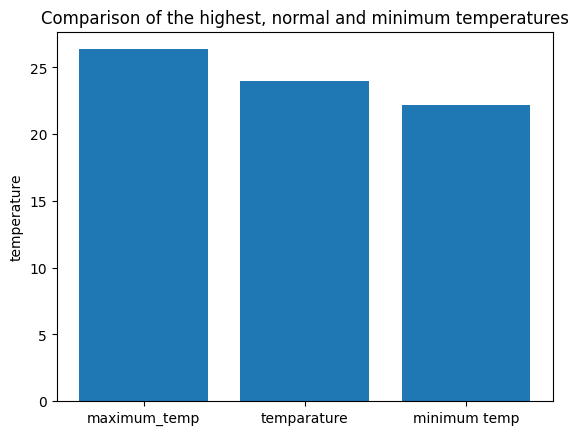

In [34]:
x = ('maximum_temp','temparature','minimum temp')
y = (df_train['maxtemp'].mean(),
     df_train['temparature'].mean(),
     df_train['mintemp'].mean())
fig,ax = plt.subplots()
ax.bar(x,y)
ax.set_ylabel('temperature')
ax.set_title('Comparison of the highest, normal and minimum temperatures');

In [44]:
# testing whether there is a significant difference in the max, temp and min
def Decision(test_results):
    if test_results[1] > 0.05:
        return f'''We fail to reject the null hypothesis,
        since p:{test_results[1]} is greater than 0.05.
        There is no significant difference in the sample means'''
    else:
        return f'''We reject the null hypothesis,
        since p:{test_results[1]} is less than 0.05.
        There is a significant difference in the sample means'''
anovatest_results = f_oneway(df_train['maxtemp'],
                        df_train['temparature'],
                        df_train['mintemp'])
Decision(anovatest_results)

'We reject the null hypothesis,\n        since p:1.4729728588838543e-142 is less than 0.05.\n        There is a significant difference in the sample means'

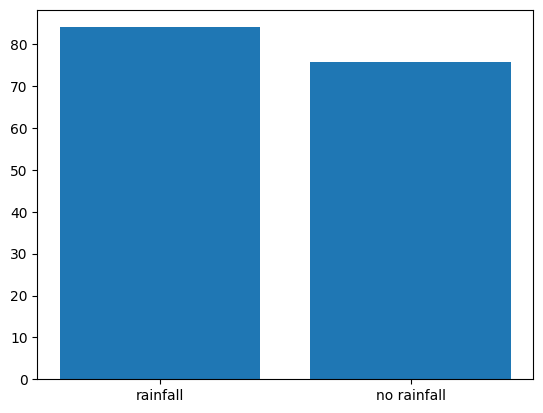

In [53]:
x = ('rainfall','no rainfall')
y = ((df_train['humidity'][df_train['rainfall']==1].mean()),
(df_train['humidity'][df_train['rainfall']==0].mean()))
plt.figure()
plt.bar(x,y);

In [48]:
ttest_results = ttest_ind((df_train['humidity'][df_train['rainfall']==1]),
                         (df_train['humidity'][df_train['rainfall']==0]))
Decision(ttest_results)

'We reject the null hypothesis,\n        since p:6.194524099285714e-112 is less than 0.05.\n        There is a significant difference in the sample means'

<Figure size 640x480 with 0 Axes>

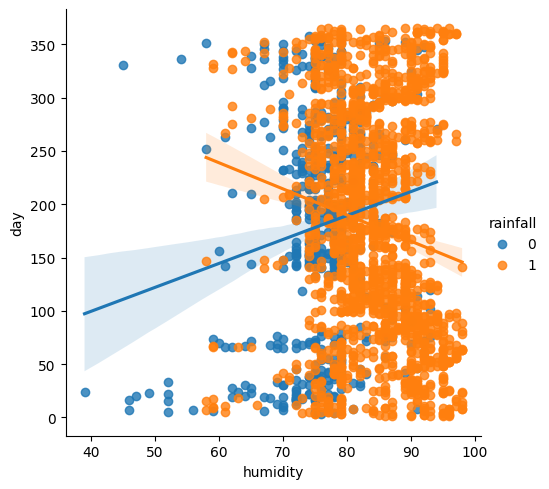

<Figure size 640x480 with 0 Axes>

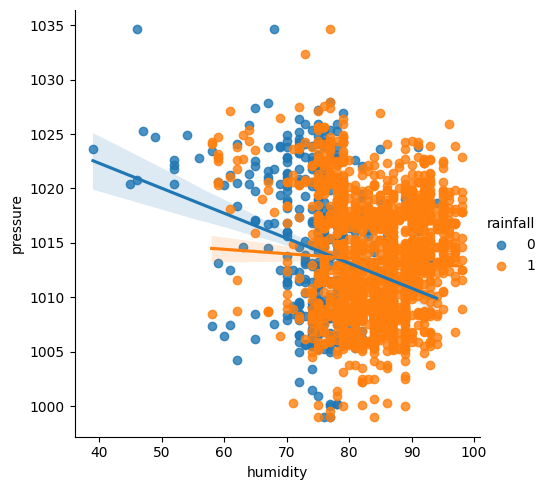

<Figure size 640x480 with 0 Axes>

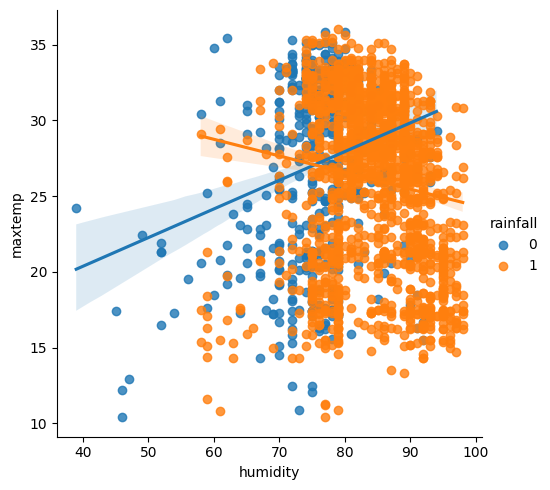

<Figure size 640x480 with 0 Axes>

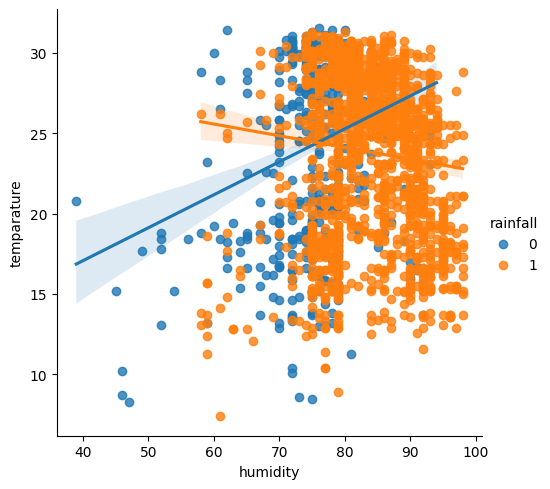

<Figure size 640x480 with 0 Axes>

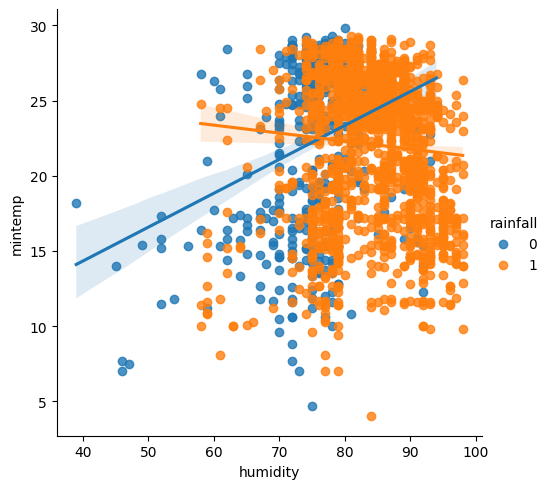

<Figure size 640x480 with 0 Axes>

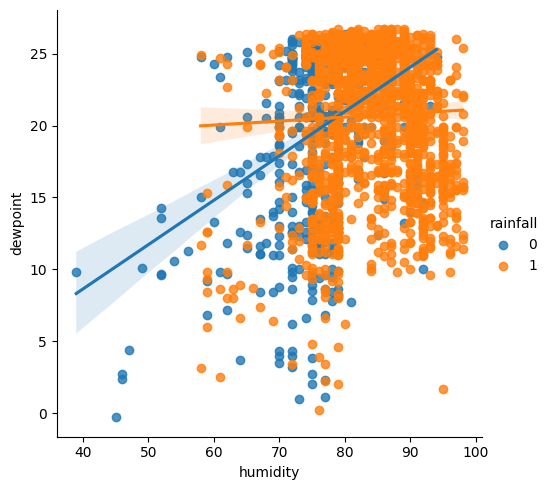

<Figure size 640x480 with 0 Axes>

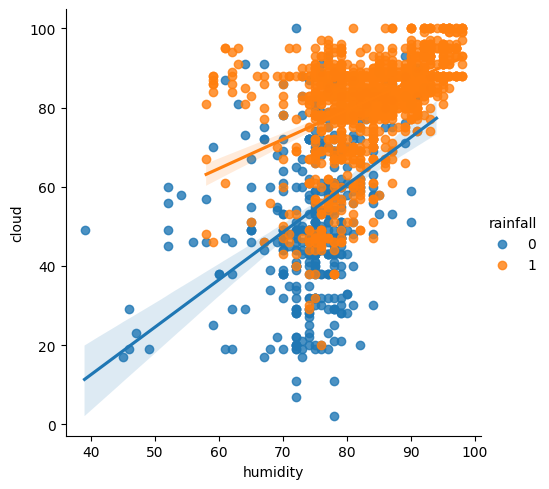

<Figure size 640x480 with 0 Axes>

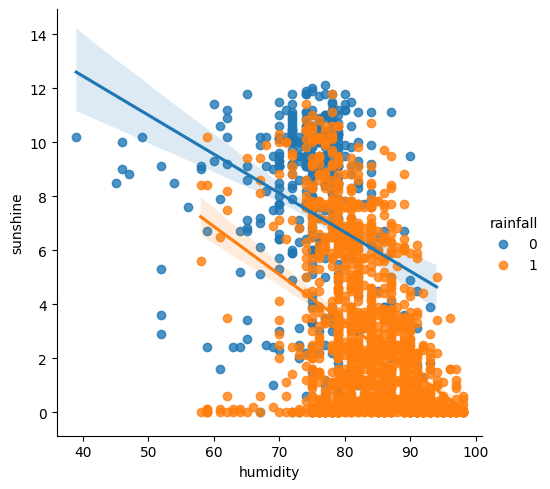

<Figure size 640x480 with 0 Axes>

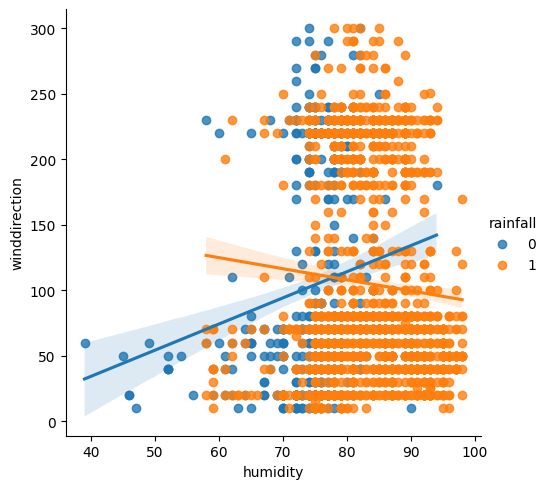

<Figure size 640x480 with 0 Axes>

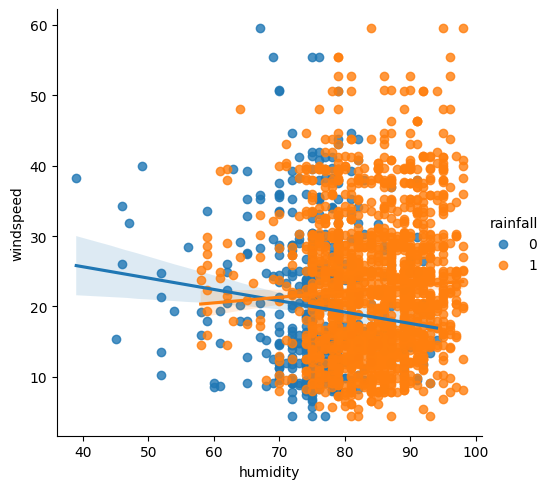

In [62]:
correlating_features = df_train.drop(columns = ['id',
                                               'rainfall','humidity'])
for feature in correlating_features.columns:
    plt.figure()
    sns.lmplot(x = 'humidity',y = feature,
               hue = 'rainfall',data = df_train);

In [63]:
X = df_train.drop(columns = ['rainfall','id'])
y = df_train['rainfall']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,
                                                 test_size = 0.25)

In [64]:
pipe = Pipeline([('Scaler',StandardScaler()),
                 ('Model',LogisticRegression())])

In [65]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('Model', LogisticRegression())])

In [66]:
y_pred = pipe.predict(X_test)

In [67]:
pipe.score(X_test,y_test)

0.8704379562043796

In [68]:
roc_auc_score(y_test,y_pred)

0.7980392156862745

In [69]:
pipe.set_params(Model = RandomForestClassifier())

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model', RandomForestClassifier())])

In [70]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model', RandomForestClassifier())])

In [71]:
y_pred = pipe.predict(X_test)

In [72]:
roc_auc_score(y_test,y_pred)

0.7835434173669467

In [75]:
pipe.set_params(Model = XGBClassifier())

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [76]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [77]:
pipe.score(X_test,y_test)

0.8448905109489051

In [78]:
y_pred = pipe.predict(X_test)

In [79]:
roc_auc_score(y_test,y_pred)

0.7714985994397758